Previous version is "Brain size of Primates with LInear Regression_v01a.ipynb"

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Data analys and plot

In [2]:
dataset = pd.read_csv("BrainAllometry_Supplement_Data.csv")

In [3]:
print(*dataset.shape)
dataset.head()

1552 14


,Binomial,order,family,genus,species,Sample_size.brain,Sample_size.body,Sex,Mean_brain_mass_g,Mean_body_mass_g,BrainReference1,BrainReference2,Brain.resid,T_resid
0,Chrysochloris_stuhlmanni,Afrosoricida,Chrysochloridae,Chrysochloris,stuhlmanni,">2,<12",NaN,Both,1.06,50.05,Boddy2012,Stephanetal.1981; Mace.etal.1981,0.010717,0.172364
1,Microgale_cowani,Afrosoricida,Tenrecidae,Microgale,cowani,1,NaN,NaN,0.42,15.20,Boddy2012,Stephanetal.1981,-0.003165,0.041996
2,Microgale_dobsoni,Afrosoricida,Tenrecidae,Microgale,dobsoni,1,NaN,NaN,0.56,32.60,Boddy2012,Stephanetal.1981,-0.126759,-0.007017
3,Oryzorictes_hova,Afrosoricida,Tenrecidae,Oryzorictes,hova,1,NaN,NaN,0.58,44.20,Boddy2012,Stephanetal.1981,-0.210674,-0.061177
4,Echinops_telfairi,Afrosoricida,Tenrecidae,Echinops,telfairi,2,NaN,NaN,0.62,87.50,Boddy2012,Stephanetal.1981,-0.404152,-0.187903


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Binomial           1552 non-null   object 
 1   order              1552 non-null   object 
 2   family             1552 non-null   object 
 3   genus              1552 non-null   object 
 4   species            1552 non-null   object 
 5   Sample_size.brain  1010 non-null   object 
 6   Sample_size.body   217 non-null    object 
 7   Sex                808 non-null    object 
 8   Mean_brain_mass_g  1552 non-null   float64
 9   Mean_body_mass_g   1552 non-null   float64
 10  BrainReference1    1552 non-null   object 
 11  BrainReference2    586 non-null    object 
 12  Brain.resid        1552 non-null   float64
 13  T_resid            1504 non-null   float64
dtypes: float64(4), object(10)
memory usage: 169.9+ KB


In [5]:
dataset.isnull().any()

Binomial             False
order                False
family               False
genus                False
species              False
Sample_size.brain     True
Sample_size.body      True
Sex                   True
Mean_brain_mass_g    False
Mean_body_mass_g     False
BrainReference1      False
BrainReference2       True
Brain.resid          False
T_resid               True
dtype: bool

In [6]:
dataset.nunique()

# dataset.family.unique()

Binomial             1552
order                  28
family                136
genus                 694
species              1259
Sample_size.brain      81
Sample_size.body       51
Sex                     6
Mean_brain_mass_g    1226
Mean_body_mass_g     1269
BrainReference1        30
BrainReference2       113
Brain.resid          1548
T_resid              1502
dtype: int64

In [7]:
primates = dataset.loc[dataset["order"] == "Primates"]
data = primates[["Mean_body_mass_g", "Mean_brain_mass_g"]]
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)
# X.tail(), Y.tail()

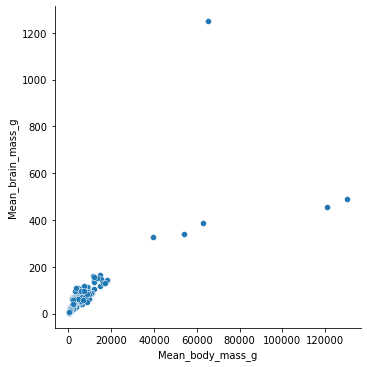

In [8]:
sns.relplot(x=train_dataset.iloc[:, 0], y=train_dataset.iloc[:, 1])

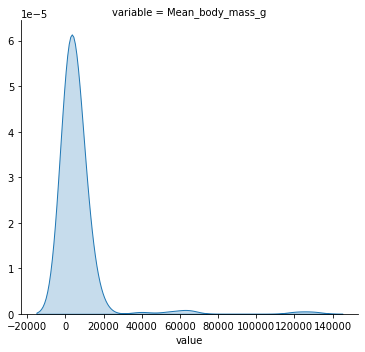

In [9]:
df = pd.melt(train_dataset, train_dataset.columns[-1], train_dataset.columns[:-1])

g = sns.FacetGrid(df, col="variable", col_wrap=2, height=5) #  hue="species",
g.map(sns.kdeplot, "value", shade=True)

plt.show()

In [10]:
train_stats = train_dataset.describe().T
train_stats

,count,mean,std,min,25%,50%,75%,max
Mean_body_mass_g,198.0,6446.687410,14660.005238,42.500000,767.250000,3410.000,6800.00000,130000.00
Mean_brain_mass_g,198.0,68.157301,108.866699,1.716402,11.899562,57.095,86.49952,1250.43


In [11]:
X = train_dataset.copy()
Y = test_dataset.copy()

X_labels = X.pop("Mean_brain_mass_g")
Y_labels = Y.pop("Mean_brain_mass_g")

### Normalize the data 
<center> $ x_{norm} = {(x - x^{train}_{\mu}) \over x^{train}_{\sigma} } $ <center>

In [12]:
# def norm(x):
#     stats = X.describe().T
#     return (x - stats['mean']) / stats['std']
#
# x_norm = norm(X)
# y_norm = norm(Y)
body_mass = np.array(X["Mean_body_mass_g"])
body_mass_norm = preprocessing.Normalization(input_shape=[1,])
body_mass_norm.adapt(body_mass)


# Model

In [121]:
lambd = 0.12
alpha = 0.15

In [122]:
brainmass_model = keras.Sequential([
    body_mass_norm,
    layers.Dense(units=3, kernel_regularizer=tf.keras.regularizers.L2(lambd)),
#     layers.Dense(units=10),
    layers.Dense(1)
])

brainmass_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense_36 (Dense)             (None, 3)                 6         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 4         
Total params: 13
Trainable params: 10
Non-trainable params: 3
_________________________________________________________________


In [123]:
brainmass_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=alpha),
    loss='mae')

In [124]:
%%time
history = brainmass_model.fit(
    X["Mean_body_mass_g"], X_labels,
    epochs=50,
    verbose=0,
    validation_split = 0.2)

Wall time: 2.04 s


In [125]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
45,28.474455,31.621658,45
46,28.702711,30.970318,46
47,28.617378,28.896595,47
48,28.749891,29.556173,48
49,28.451649,30.442587,49


train_cost = 28.451648712158203 
 dev_cost = 30.44258689880371
 test_cost = 28.790790557861328



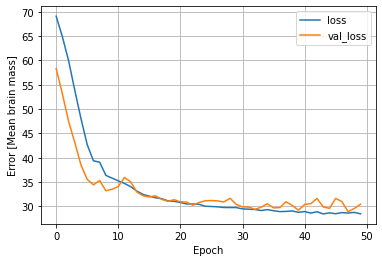

In [126]:
test_results = {}

test_results['Mean_body_mass_model'] = brainmass_model.evaluate(
    X["Mean_body_mass_g"],
    X_labels, verbose=0)


def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
#     plt.ylim([0, 70])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Mean brain mass]')
    plt.legend()
    plt.grid(True)

    
print("train_cost = %s \n" % hist["loss"].iloc[-1], 
      "dev_cost = %s\n" % hist["val_loss"].iloc[-1], 
      "test_cost = %s\n" % test_results['Mean_body_mass_model'])
plot_loss(history)

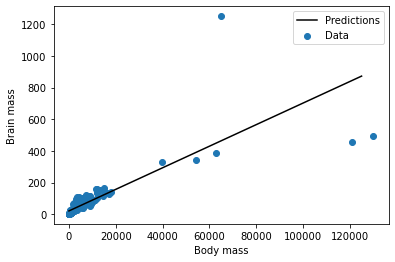

In [108]:
x = tf.linspace(0., 125000, 1000)
y = brainmass_model.predict(x)

def plot_brainmass(x, y):
    plt.scatter(X["Mean_body_mass_g"], X_labels, label="Data")
    plt.plot(x, y, color='k', label='Predictions')
#     plt.ylim([0, 5000])
    plt.xlabel('Body mass')
    plt.ylabel('Brain mass')
    plt.legend()

plot_brainmass(x, y)

## Early stopping 

train_cost = 29.69977569580078 
 dev_cost = 30.0238037109375
 test_cost = 26.192119598388672



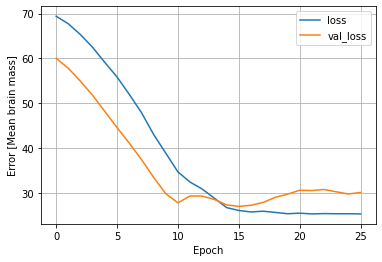

In [20]:
brainmass_model = keras.Sequential([
    body_mass_norm,
    layers.Dense(units=3),
#     layers.Dense(units=10),
    layers.Dense(1)])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

brainmass_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=alpha),
    loss='mae')

history = brainmass_model.fit(
    X["Mean_body_mass_g"], X_labels,
    epochs=50,
    verbose=0,
    validation_split = 0.2,
    callbacks= early_stop)


test_results = {}

test_results['Mean_body_mass_model'] = brainmass_model.evaluate(
    X["Mean_body_mass_g"],
    X_labels, verbose=0)


print("train_cost = %s \n" % hist["loss"].iloc[-1], 
      "dev_cost = %s\n" % hist["val_loss"].iloc[-1], 
      "test_cost = %s\n" % test_results['Mean_body_mass_model'])
plot_loss(history)

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
21,25.257305,30.478943,21
22,25.329479,30.710886,22
23,25.294228,30.195181,23
24,25.295910,29.708094,24
25,25.256067,30.041187,25


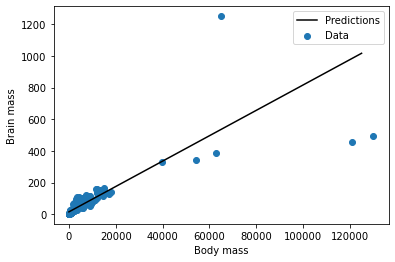

In [22]:
x = tf.linspace(0., 125000, 1000)
y = brainmass_model.predict(x)

def plot_brainmass(x, y):
    plt.scatter(X["Mean_body_mass_g"], X_labels, label="Data")
    plt.plot(x, y, color='k', label='Predictions')
#     plt.ylim([0, 5000])
    plt.xlabel('Body mass')
    plt.ylabel('Brain mass')
    plt.legend()

plot_brainmass(x, y)